In [1]:
#%run "0a_Workspace_setup.ipynb"
%run "0b_Create_poi_files.ipynb"

"model_output_file" folder --exists.

Project Folder (root directory) C:\Projects\Repositories\OR_Recharge_Project

Selected model (folder) is "20240927_v1.1_gm_byHWons_san_jacinto_2"

model parameter file : myparam.param

"notebook_output_files" folder --exists.

"shapefiles" folder --exists.

"GeoDataFrames" folder --exists.

"Folium_maps" folder --exists.

"nc_files" folder --exists.

Resource folders:

NHM  "C:\Projects\Repositories\OR_Recharge_Project/NHM_source_files"

Notebook directory "C:\Projects\Repositories\OR_Recharge_Project\NHM-Assist"

The default gage file will be used and has 130 gages.

WARNING: Gage [] missing metadata and will be dropped from the poi_gdf.

The gages file has 130 streamflow gages, 130 are in NWIS.

The parameter file has 48 gages, 0 are missing metadata and 
cannot be mapped in NHMassist notebooks unless the gages.csv is modified.

An additional 82 streamflow gages are in the model domain and not in the parameter file; 82 are in NWIS.

## Scraper functions

In [2]:
def owrd_scraper(station_nbr, start_date, end_date):
    # f string the args into the urldf
    url = f'https://apps.wrd.state.or.us/apps/sw/hydro_near_real_time/hydro_download.aspx?station_nbr={station_nbr}&start_date={start_date}&end_date={end_date}&dataset=MDF&format=html'

    # open and decode the url
    resource = request.urlopen(url)
    content =  resource.read().decode(resource.headers.get_content_charset())

    # Ugly parsing between pre tags
    # initializing substrings
    sub1 = "<pre>"
    sub2 = "</pre>"

    # getting index of substrings
    idx1 = content.index(sub1)
    idx2 = content.index(sub2)

    res = ''
    # getting elements in between
    for idx in range(idx1 + len(sub1), idx2):
        res = res + content[idx]
    
    # make and return the pandas df
    
    # NOTE:
    # Read in the csv file taking care to set the data types exactly. This is important for stability and functionality. 
    # This should be done everytime the databases are read into this and future notebooks!

    col_names = ['station_nbr',
             'record_date',
             'mean_daily_flow_cfs',
             #'published_status',
             #'estimated',
             #'revised',
             #'download_date',
            ]
    col_types = [np.str_,
             np.str_,
             float,
             #np.str_,
             #np.str_,
             #float,
             #np.str_,
            ]
    cols = dict(zip(col_names, col_types))# Creates a dictionary of column header and datatype called below.

    owrd_df = pd.read_csv(StringIO(res), sep='\t', header=0, dtype=cols)
    owrd_df
    return owrd_df

def ecy_scrape(station, ecy_years):
    ecy_df_list = []
    for ecy_year in ecy_years:
        url = f'https://apps.ecology.wa.gov/ContinuousFlowAndWQ/StationData/Prod/{station}/{station}_{ecy_year}_DSG_DV.txt'    
        try:
            # The string that is to be searched
            key = "DATE"
             
            # Opening the file and storing its data into the variable lines
            with urlopen(url) as file:
                lines = file.readlines()
             
            # Going over each line of the file
            dateline = []
            for number, line in enumerate(lines, 1):  
     
                # Condition true if the key exists in the line
                # If true then display the line number
                if key in str(line):  
                    dateline.append(number)
                    # print(f'{key} is at line {number}')  
            # df = pd.read_csv(url, skiprows=11, sep = '\s{3,}', on_bad_lines='skip', engine = 'python')  # looks for at least three spaces as separator
            df = pd.read_fwf(url, skiprows=dateline[0]) # seems to handle formatting for No Data and blanks together, above option is thrown off by blanks
            # df['Day'] = pd.to_numeric(df['Day'], errors='coerce') # day col to numeric
            # df = df[df['Day'].notna()].astype({'Day': int}) # 
            # df = df.drop('Day.1', axis=1)
            if len(df.columns) == 3:
                df.columns = ['time', 'discharge', 'Quality']
            elif len(df.columns) == 4:
                df.columns = ['time', 'utc', 'discharge', 'Quality']
                df.drop('utc', axis = 1, inplace = True)
            try:
                df.drop('Quality', axis = 1, inplace = True) # drop quality for now, might use to filter later
            except KeyError:
                print(f'no Quality for {station} {ecy_year}')
            df['time'] = pd.to_datetime(df['time'], errors='coerce')
            df = df.dropna(subset=['time'])
            df['poi_id'] = station
            df["discharge"] = pd.to_numeric(df["discharge"], errors = 'coerce')
            # specify data types
            dtype_map = {'poi_id': str, 
                         'time': 'datetime64[ns]'}
            df = df.astype(dtype_map)

            df.set_index(['poi_id', 'time'], inplace=True)
            # next two lines are new if this breaks...
            idx = pd.IndexSlice
            df = df.loc[idx[:, ecy_start_date:ecy_end_date], :] # filters to the date range
            df['agency_id'] = 'ECY'

            ecy_df_list.append(df)
            print(f'good year {ecy_year}')
            print(url)
        except HTTPError:
            pass
        except ValueError as ex:
            print(ex)
            print(ecy_year)
    if len(df) != 0:
        ecy_df = pd.concat(ecy_df_list)
        # ecy_df["discharge_cfs"] = pd.to_numeric(ecy_df["discharge_cfs"], errors = 'coerce')
        return ecy_df
    else:
        print(f'No data for station {station} for data range {ecy_years}.')
        return None

#### Set start and end dates for streamflow daily time series

In [3]:
# Set start and end times in format 'mm/dd/YYYY'
start_date = '01/01/1979'
end_date = '12/31/2022'

# Get daily streamflow data for gages
##### We will not use the list of gages in the model paramter file, but will use the gages lsited in the gages_file.csv. This The reasoning: there may be multiple observation datasets that are associated with a single segment outflow (gage_poi), and, in the parameter file, only one poi_gage can be associated with a segment. We want a streamflow data set that is more inclusive.

## Create Xarray dataset with station information (indexed by poi_id)

In [4]:
# The Stations file now becomes the source of the gage metadata
xr_station_info = xr.Dataset.from_dataframe(gages_df)
#xr_station_info

## Download OWRD streamflow data set

In [5]:
print(owrd_domain)

no


In [6]:
%%time
# CPU times: user 3min 49s, sys: 51.3 s, total: 4min 40s
# Wall time: 35min 18s
if owrd_domain == 'no':
    con.print("There are no OWRD gages in the model domain.")

if owrd_domain == 'yes':
    owrd_cache_file = model_dir / 'notebook_output_files' / 'nc_files' /'owrd_cache.nc'
    lst = []
    
    if owrd_cache_file.exists():
        with xr.open_dataset(owrd_cache_file) as owrd_ds:
            #ds = xr.open_dataset(owrd_cache_file)
            owrd_df = owrd_ds.to_dataframe()
        print('Cached copy of OWRD data exists. To re-download the data remove the cache file.')
        print(owrd_cache_file)
    else:
        with Progress() as progress:
            task = progress.add_task('[red]Downloading...', total=len(poi_df))
        
            # Get the streamflow data. This will return a list of lists 
            #         a time series for each gage..[[gage0], [gage1], [gage2]...[gagen]]
            for ii in gages_df.index:
                lst.append(owrd_scraper(ii, start_date, end_date))
                progress.update(task, advance=1)
    
    
        owrd_df = pd.concat(lst)   # Converts the list of df's to a single df
        
        # Rename field names
        field_map = {'station_nbr': 'poi_id', 
                     'record_date': 'time',
                     'mean_daily_flow_cfs': 'discharge',
                     'station_name': 'poi_name'}
        owrd_df.rename(columns=field_map, inplace=True)
        
        # Change the datatype for poi_id
        dtype_map = {'poi_id': str, 
                     'time': 'datetime64[ns]'}
        owrd_df = owrd_df.astype(dtype_map)
        
        # Drop the columns we don't need
        drop_cols = ['download_date', 'estimated', 'revised', 'published_status']
        owrd_df.drop(columns=drop_cols, inplace=True)
        
        # Add new fields
        owrd_df['agency_id'] = 'OWRD'   # Creates tags for all OWRD daily streamflow data
    
        # See a multi-index
        owrd_df.set_index(['poi_id', 'time'], inplace=True)
    
        owrd_ds = xr.Dataset.from_dataframe(owrd_df)
    
        # Set attributes for the variables
        owrd_ds['discharge'].attrs = {'units': 'ft3 s-1', 
                                 'long_name': 'discharge'}
        owrd_ds['poi_id'].attrs = {'role': 'timeseries_id', 
                              'long_name': 'Point-of-Interest ID', 
                              '_Encoding': 'ascii'}
        owrd_ds['agency_id'].attrs = {'_Encoding': 'ascii'}
        
        # Set encoding
        # See 'String Encoding' section at https://crusaderky-xarray.readthedocs.io/en/latest/io.html
        owrd_ds['poi_id'].encoding.update({'dtype': 'S15',
                                      'char_dim_name': 'poiid_nchars'})
        
        
        owrd_ds['time'].encoding.update({'_FillValue': None,
                                    'standard_name': 'time',
                                    'calendar': 'standard', 
                                    'units': 'days since 1940-01-01 00:00:00'})
        
        owrd_ds['agency_id'].encoding.update({'dtype': 'S5',
                                         'char_dim_name': 'agency_nchars'})
        
        # Add fill values to the data variables
        var_encoding = dict(_FillValue=netCDF4.default_fillvals.get('f4'))
        
        for cvar in owrd_ds.data_vars:
            if cvar not in ['agency_id']:
                owrd_ds[cvar].encoding.update(var_encoding)
        
        # add global attribute metadata
        owrd_ds.attrs={'Description': 'Streamflow data for PRMS', 
                  'FeatureType': 'timeSeries'}
        
        # Write the dataset to a netcdf file
        owrd_ds.to_netcdf(owrd_cache_file)

There are no OWRD gages in the model domain.

CPU times: total: 0 ns
Wall time: 1.07 ms


In [7]:
#owrd_ds

## Download ECY streamflow data set

In [8]:
# get the dates for ecy_scrape
if owrd_domain == 'no':
    con.print("There are no ECY gages in the model domain.")

if owrd_domain == 'yes':
    ecy_cache_file = model_dir / 'notebook_output_files' / 'nc_files' /'ecy_cache.nc'
    
    ecy_start_date = dt.datetime.strptime(start_date, '%m/%d/%Y').strftime('%Y-%m-%d')
    ecy_end_date = dt.datetime.strptime(end_date, '%m/%d/%Y').strftime('%Y-%m-%d')
    
    # create a year range for ecy data
    ecy_start_year = dt.datetime.strptime(start_date, '%m/%d/%Y')
    ecy_end_year = dt.datetime.strptime(end_date, '%m/%d/%Y')
    
    # add 1 year to date range because ecy is water year, add another because for range is not inclusive
    ecy_years = range(ecy_start_year.year, ecy_end_year.year + 2)
    ecy_years

There are no ECY gages in the model domain.

In [9]:
# find ecology gages in the gage list, they are 6 alpha numeric, third is char
if owrd_domain == 'no':
    pass

if owrd_domain == 'yes':
    ecy_gages = []
    # gage_list = ['01C070', '03D050', '32B075', '32B090', '32B100', '32A100', '32A105', '32A120'] # change this list to that from the stations list
    gage_list = gages_df.index.to_list()
    for i in gage_list:
        # if len(i) == 6 and i.matches("^[A-Z]{1}\\d{3}") 
        if len(i) == 6 and i[0:2].isdigit() and i[2].isalpha() and i[4:6].isdigit():
            ecy_gages.append(i)
        else:
            pass
    ecy_gages

In [10]:
%%time

if owrd_domain == 'no':
    pass #con.print("There are no OWRD gages in the model domain.")

if owrd_domain == 'yes':
    ecy_df_list = []
    
    if ecy_cache_file.exists():
        with xr.open_dataset(ecy_cache_file) as ecy_ds:
            ecy_df = ecy_ds.to_dataframe()
        print('Cached copy of ECY data exists. To re-download the data remove the cache file.')
        print(ecy_cache_file)
    else:
        with Progress() as progress:
            task = progress.add_task('[red]Downloading...', total=len(ecy_gages))
        
            # Get the streamflow data. This will return a list of lists 
            #         a time series for each gage..[[gage0], [gage1], [gage2]...[gagen]]
            for ii in ecy_gages:
                try:
                    ecy_df_list.append(ecy_scrape(ii, ecy_years))
                    progress.update(task, advance=1)
                except UnboundLocalError:
                    print(f'No data for {ii}')
                    progress.update(task, advance=1)
                    pass
    
    
        ecy_df = pd.concat(ecy_df_list)   # Converts the list of df's to a single df
        
        # set the multiIndex
        # ecy_df.set_index(['poi_id', 'time'], inplace=True)
        # # Change the datatype for poi_id
    
        ecy_df = ecy_df[~ecy_df.index.duplicated(keep='first')] # overlap in ecy records for 10-1, drop duplicates for xarray 
        # ecy_df = ecy_df.join(ecy_station_info_df, how='inner') # bring in station info

        # Add new fields
        ecy_df['agency_id'] = 'ECY'   # Creates tags for all ECY daily streamflow data
        
        ecy_ds = xr.Dataset.from_dataframe(ecy_df)
    
        # Set attributes for the variables
        ecy_ds['discharge'].attrs = {'units': 'ft3 s-1', 
                                 'long_name': 'discharge'}
        ecy_ds['poi_id'].attrs = {'role': 'timeseries_id', 
                              'long_name': 'Point-of-Interest ID', 
                              '_Encoding': 'ascii'}
        ecy_ds['agency_id'].attrs = {'_Encoding': 'ascii'}
        
        # Set encoding
        # See 'String Encoding' section at https://crusaderky-xarray.readthedocs.io/en/latest/io.html
        ecy_ds['poi_id'].encoding.update({'dtype': 'S15',
                                      'char_dim_name': 'poiid_nchars'})
        
        ecy_ds['time'].encoding.update({'_FillValue': None,
                                    'standard_name': 'time',
                                    'calendar': 'standard', 
                                    'units': 'days since 1940-01-01 00:00:00'})
        
        ecy_ds['agency_id'].encoding.update({'dtype': 'S5',
                                         'char_dim_name': 'agency_nchars'})
        
        # Add fill values to the data variables
        var_encoding = dict(_FillValue=netCDF4.default_fillvals.get('f4'))
        
        for cvar in ecy_ds.data_vars:
            if cvar not in ['agency_id']:
                ecy_ds[cvar].encoding.update(var_encoding)
        
        # add global attribute metadata
        ecy_ds.attrs={'Description': 'Streamflow data for PRMS', 
                  'FeatureType': 'timeSeries'}
    
        # ecy_ds = (ecy_ds.sel(time=slice(ecy_start_date, ecy_end_date))) # get the values only between the start and end date
    
        # Write the dataset to a netcdf file
        ecy_ds.to_netcdf(ecy_cache_file)

CPU times: total: 0 ns
Wall time: 0 ns


Note: ecy_ds is going outside of the date range. use the time slice using ecy_start_date and ecy_end_date

In [11]:
#ecy_ds

## Download NWIS streamflow data set

### Make a list of NWIS gages in the model domain

In [12]:
nwis_gages_aoi.set_index('poi_id', inplace=True)
nwis_gages_list = nwis_gages_aoi.index.values.tolist()

### Change start/end date format to match nwis retrieval tool

In [13]:
nwis_start = datetime.datetime.strptime(start_date, "%m/%d/%Y").strftime("%Y-%m-%d")
nwis_end = datetime.datetime.strptime(end_date, "%m/%d/%Y").strftime("%Y-%m-%d")
con.print(f'We will retrieve NWIS records beginning on {nwis_start} and ending on {nwis_end}.')

We will retrieve NWIS records beginning on 1979-01-01 and ending on 2022-12-31.

### Retrieve daily streamflow data from NWIS

In [14]:
gages_df

,poi_agency,poi_name,latitude,longitude,drainage_area,drainage_area_contrib
poi_id,,,,,,
08072300,USGS,"Buffalo Bayou nr Katy, TX",29.743286,-95.806890,63.30,63.30
08078910,USGS,"Oyster Ck at FM 1092 nr Missouri City, TX",29.573480,-95.563934,NaN,NaN
08075400,USGS,"Sims Bayou at Hiram Clarke St, Houston, TX",29.618843,-95.446050,20.20,20.20
08078890,USGS,"Oyster Ck at FM 1464 nr Sugar Land, TX",29.619205,-95.683610,NaN,NaN
08074900,USGS,"Willow Waterhole Br at Landsdowne, Houston, TX",29.650510,-95.486610,3.81,3.81
...,...,...,...,...,...,...
08069800,USGS,"E Fk San Jacinto Rv at SH 150 nr Coldspring, TX",30.566944,-95.191390,91.90,NaN
08067555,USGS,"East Sandy Ck at FM 1374 nr New Waverly, TX",30.583963,-95.566260,NaN,NaN
08067552,USGS,"West Sandy Ck at FM 1791 nr Richards, TX",30.603884,-95.725220,NaN,NaN


In [15]:
%%time
NWIS_tmp = []

with Progress() as progress:
    task = progress.add_task('[red]Downloading...', total=len(gages_df))
    
    for ii in gages_df.index:
        if str(ii) in nwis_gages_list:
            NWISgage_data = nwis.get_record(sites= (str(ii)), service='dv', start=nwis_start, end=nwis_end)
            NWIS_tmp.append(NWISgage_data)
        else:
            pass
        progress.update(task, advance=1)

NWIS_ds = pd.concat(NWIS_tmp)

Output()

CPU times: total: 10.9 s
Wall time: 1min 25s


### Clean up the NWIS timeseries and add 'agency_id' variable (value= 'USGS') for each daily obs.

In [16]:
# we only need site_no and discharge (00060_Mean)
NWIS_ds = NWIS_ds[['site_no', '00060_Mean']].copy()
NWIS_ds['agency_id'] = 'USGS'

NWIS_ds = NWIS_ds.tz_localize(None)
NWIS_ds.reset_index(inplace=True)

# rename cols to match other df
NWIS_ds.rename(columns={'datetime': 'time',
                          '00060_Mean': 'discharge',
                          'site_no': 'poi_id'},
                 inplace=True)

NWIS_ds.set_index(['poi_id', 'time'], inplace=True)

In [17]:
NWIS_ds

discharge agency_id
poi_id   time                           
08072300 1979-01-01     733.00      USGS
         1979-01-02     309.00      USGS
         1979-01-03     131.00      USGS
         1979-01-04      90.00      USGS
         1979-01-05     120.00      USGS
...                        ...       ...
08067548 2022-12-27       2.71      USGS
         2022-12-28       2.33      USGS
         2022-12-29       2.23      USGS
         2022-12-30     351.00      USGS
         2022-12-31     585.00      USGS

[710333 rows x 2 columns]

## Combine NWIS with OWRD and ECY daily streamflow (if nedded)
note: all NWIS data is mirrored the OWRD database without any primary source tags. This section will also etermine the original source or each daily observation and create a tag for each daily record.

In [18]:
owrd_domain

'no'

In [19]:
if owrd_domain == 'no':
    streamflow_df = NWIS_ds.copy()

if owrd_domain == 'yes':
    # Merge NWIS and OWRD
    NWIS_OWRD_joined = pd.concat([NWIS_ds, owrd_df]) #Join the two datasets
    # Drop duplicated indexes, keeping the first occurence (USGS occurs first)
    # try following this thing: https://saturncloud.io/blog/how-to-drop-duplicated-index-in-a-pandas-dataframe-a-complete-guide/#:~:text=Pandas%20provides%20the%20drop_duplicates(),names%20to%20the%20subset%20parameter.
    NWIS_OWRD_clean = NWIS_OWRD_joined[~NWIS_OWRD_joined.index.duplicated(keep='first')]
    
    # Merge with ECY
    NWIS_OWRD_ECY_joined = pd.concat([NWIS_OWRD_clean, ecy_df])
    # drop duplicated indexes, keeping the last occurence (ECY occurs last). Only dups now should be ecy
    # try following this thing: https://saturncloud.io/blog/how-to-drop-duplicated-index-in-a-pandas-dataframe-a-complete-guide/#:~:text=Pandas%20provides%20the%20drop_duplicates(),names%20to%20the%20subset%20parameter.
    NWIS_OWRD_ECY_clean = NWIS_OWRD_ECY_joined[~NWIS_OWRD_ECY_joined.index.duplicated(keep='last')]

    streamflow_df = NWIS_OWRD_ECY_clean.copy()

In [20]:
streamflow_df

discharge agency_id
poi_id   time                           
08072300 1979-01-01     733.00      USGS
         1979-01-02     309.00      USGS
         1979-01-03     131.00      USGS
         1979-01-04      90.00      USGS
         1979-01-05     120.00      USGS
...                        ...       ...
08067548 2022-12-27       2.71      USGS
         2022-12-28       2.33      USGS
         2022-12-29       2.23      USGS
         2022-12-30     351.00      USGS
         2022-12-31     585.00      USGS

[710333 rows x 2 columns]

#### Poteniatlly important code later for checking stuff

## Create Xarray dataset with streamflow date set (indexed by poi_id and time)

In [21]:
xr_streamflow_only = xr.Dataset.from_dataframe(streamflow_df)
xr_streamflow_only

<xarray.Dataset> Size: 24MB
Dimensions:    (poi_id: 94, time: 16071)
Coordinates:
  * poi_id     (poi_id) object 752B '08041940' '08041970' ... '08079000'
  * time       (time) datetime64[ns] 129kB 1979-01-01 1979-01-02 ... 2022-12-31
Data variables:
    discharge  (poi_id, time) float64 12MB nan nan nan nan ... nan nan nan nan
    agency_id  (poi_id, time) object 12MB nan nan nan nan ... nan nan nan nan

## Make and Xarray data set for NWIS, OWRD, and WA Ecology data and encode with station information

In [22]:
xr_streamflow = xr.merge([xr_streamflow_only, xr_station_info], combine_attrs='drop_conflicts')
#xr_streamflow

In [23]:
test_poi= xr_streamflow.poi_id.values[2]

# xr_streamflow.discharge.sel[poi_id = '32N070'].to_dataframe()
xr_streamflow.agency_id.sel(poi_id=test_poi).to_dataframe().agency_id.unique()

array([nan], dtype=object)

In [24]:
# Set attributes for the variables
xr_streamflow['discharge'].attrs = {'units': 'ft3 s-1', 
                                'long_name': 'discharge'}
xr_streamflow['drainage_area'].attrs = {'units': 'mi2', 'long_name': 'Drainage Area'}
xr_streamflow['drainage_area_contrib'].attrs = {'units': 'mi2', 'long_name': 'Effective drainage area'}
xr_streamflow['latitude'].attrs = {'units': 'degrees_north', 'long_name': 'Latitude'}
xr_streamflow['longitude'].attrs = {'units': 'degrees_east', 'long_name': 'Longitude'}
xr_streamflow['poi_id'].attrs = {'role': 'timeseries_id', 
                             'long_name': 'Point-of-Interest ID', 
                             '_Encoding': 'ascii'}
xr_streamflow['poi_name'].attrs = {'long_name': 'Name of POI station', '_Encoding': 'ascii'}
xr_streamflow['time'].attrs = {'standard_name': 'time'}
xr_streamflow['poi_agency'].attrs = {'_Encoding': 'ascii'}
xr_streamflow['agency_id'].attrs = {'_Encoding': 'ascii'}

# Set encoding
# See 'String Encoding' section at https://crusaderky-xarray.readthedocs.io/en/latest/io.html
xr_streamflow['poi_id'].encoding.update({'dtype': 'S15',
                                     'char_dim_name': 'poiid_nchars'})

xr_streamflow['time'].encoding.update({'_FillValue': None,
                                   'calendar': 'standard', 
                                   'units': 'days since 1940-01-01 00:00:00'})

xr_streamflow['latitude'].encoding.update({'_FillValue': None})
xr_streamflow['longitude'].encoding.update({'_FillValue': None})

xr_streamflow['agency_id'].encoding.update({'dtype': 'S5',
                                        'char_dim_name': 'agency_nchars'})

xr_streamflow['poi_name'].encoding.update({'dtype': 'S50',
                                       'char_dim_name': 'poiname_nchars'})

xr_streamflow['poi_agency'].encoding.update({'dtype': 'S5',
                                                   'char_dim_name': 'mro_nchars',
                                                  '_FillValue': ''})
# Add fill values to the data variables
var_encoding = dict(_FillValue=netCDF4.default_fillvals.get('f4'))

for cvar in xr_streamflow.data_vars:
    if xr_streamflow[cvar].dtype != object and cvar not in ['latitude', 'longitude']:
        xr_streamflow[cvar].encoding.update(var_encoding)

# add global attribute metadata
xr_streamflow.attrs={'Description': 'Streamflow data for PRMS', 
                 'FeatureType': 'timeSeries'}

## Assign EFC values to the Xarray dataset

In [25]:
# Attributes for the EFC-related variables
attributes = {'efc': {'dtype': np.int32,
                      'attrs': {'long_name': 'Extreme flood classification',
                                '_FillValue': -1, 
                                'valid_range': [1, 5],
                                'flag_values': [1, 2, 3, 4, 5],
                                'flag_meanings': 'large_flood small_flood high_flow_pulse low_flow extreme_low_flow'}
                     },
              'ri': {'dtype': np.float32,
                     'attrs': {'long_name': 'Recurrence interval',
                               '_FillValue': 9.96921e+36,
                               'units': 'year'}
                    },
              'high_low': {'dtype': np.int32,
                           'attrs': {'long_name': 'Discharge classification',
                                     '_FillValue': -1,
                                     'valid_range': [1, 3],
                                     'flag_values': [1, 2, 3],
                                     'flag_meanings': 'low_flow ascending_limb descending_limb'}
                          }
             }

In [26]:
# var_enc = {}
# for var, info in attributes.items():
#     # Add the variable
#     xr_merged[var] = xr.zeros_like(xr_merged['discharge'], dtype=info['dtype'])
    
#     var_enc[var] = {'zlib': True, 'complevel': 2}

#     # Take care of the attributes
#     del xr_merged[var].attrs['units']
    
#     for kk, vv in info['attrs'].items():
#         if kk == '_FillValue':
#             var_enc[var][kk] = vv
#         else:
#             xr_merged[var].attrs[kk] = vv

In [27]:
var_enc = {}
for var, info in attributes.items():
    # Add the variable
    xr_streamflow[var] = xr.zeros_like(xr_streamflow['discharge'], dtype=info['dtype'])
    
    var_enc[var] = {'zlib': True, 'complevel': 2}

    # Take care of the attributes
    del xr_streamflow[var].attrs['units']
    
    for kk, vv in info['attrs'].items():
        if kk == '_FillValue':
            var_enc[var][kk] = vv
        else:
            xr_streamflow[var].attrs[kk] = vv

In [28]:
%%time
flow_col = 'discharge'

for pp in xr_streamflow.poi_id.data:
    try: 
        df = efc.efc(xr_streamflow.discharge.sel(poi_id=pp).to_dataframe(), flow_col=flow_col)

        # Add EFC values to the xarray dataset for the poi
        xr_streamflow['efc'].sel(poi_id=pp).data[:] = df.efc.values
        xr_streamflow['high_low'].sel(poi_id=pp).data[:] = df.high_low.values
        xr_streamflow['ri'].sel(poi_id=pp).data[:] = df.ri.values
    except TypeError: 
        pass

CPU times: total: 52.1 s
Wall time: 1min 13s


### Plot individual POI with EFC highlighted

In [29]:
# Helper functions for plotting, developed by P.A. Norton, USGS Dakota Water Science Center
def plot_efc(df, flow_col):
    fig, ax = plt.subplots(nrows=1, figsize=(15, 5), layout='tight')
    
    mkrsize = 9.1
    
    # cmap = ListedColormap(['#000000', '#cb4335', '#f8c471', '#95a5a6', '#76d7c4', '#154360'])
    cmap = ['#000000', '#cb4335', '#f8c471', '#95a5a6', '#76d7c4', '#154360']
    labels = ['', 'Large flood', 'Small flood', 'High flow pulse', 'Low flow', 'Extreme low flow']
    
    ax.plot(df.index, df[flow_col], c='grey', lw=.5, alpha=0.5)
    
    for xx in range(1,6):
        sdf = df[df['efc'] == xx]
        
        if sdf.shape[0] != 0:
            ax.scatter(sdf.index, sdf[flow_col], c=cmap[xx], s=mkrsize, lw=0, alpha=0.7, label=labels[xx])

    ax.set_title('Extreme flood classifications', fontsize=10)
    ax.legend(loc='upper left', framealpha=0.5)


def plot_high_low(df, flow_col):
    fig, ax = plt.subplots(nrows=1, figsize=(15, 5), layout='tight')
    
    mkrsize = 9.1
    
    cmap = ['', '#00cc66','#ff9933','#9933ff']
    labels = ['', 'Low flow', 'Ascending limb', 'Descending limb']
    
    ax.plot(df.index, df[flow_col], c='grey', lw=.5, alpha=0.5)
    
    for xx in range(1,4):
        sdf = df[df['high_low'] == xx]
        
        if sdf.shape[0] != 0:
            ax.scatter(sdf.index, sdf[flow_col], c=cmap[xx], s=mkrsize, lw=0, alpha=0.7, label=labels[xx])

    ax.set_title('High/Low classifications', fontsize=10)
    ax.legend(loc='upper left', framealpha=0.5)    

In [30]:
xr_streamflow

<xarray.Dataset> Size: 59MB
Dimensions:                (poi_id: 130, time: 16071)
Coordinates:
  * poi_id                 (poi_id) object 1kB '08041940' ... '08079000'
  * time                   (time) datetime64[ns] 129kB 1979-01-01 ... 2022-12-31
Data variables:
    discharge              (poi_id, time) float64 17MB nan nan nan ... nan nan
    agency_id              (poi_id, time) object 17MB nan nan nan ... nan nan
    poi_agency             (poi_id) object 1kB 'USGS' 'USGS' ... 'USGS' 'USGS'
    poi_name               (poi_id) object 1kB 'Green Pond Gully at FM 365 nr...
    latitude               (poi_id) float64 1kB 29.95 29.83 ... 29.35 29.16
    longitude              (poi_id) float64 1kB -94.33 -94.3 ... -95.52 -95.48
    drainage_area          (poi_id) float64 1kB nan nan 262.0 ... nan nan 114.0
    drainage_area_contrib  (poi_id) float64 1kB nan nan 262.0 ... nan nan 114.0
    efc                    (poi_id, time) int32 8MB -1 -1 -1 -1 ... -1 -1 -1 -1
    ri                     (poi_id, time) float32 8MB nan nan nan ... nan nan
    high_low               (poi_id, time) int32 8MB -1 -1 -1 -1 ... -1 -1 -1 -1
Attributes:
    Description:  Streamflow data for PRMS
    FeatureType:  timeSeries

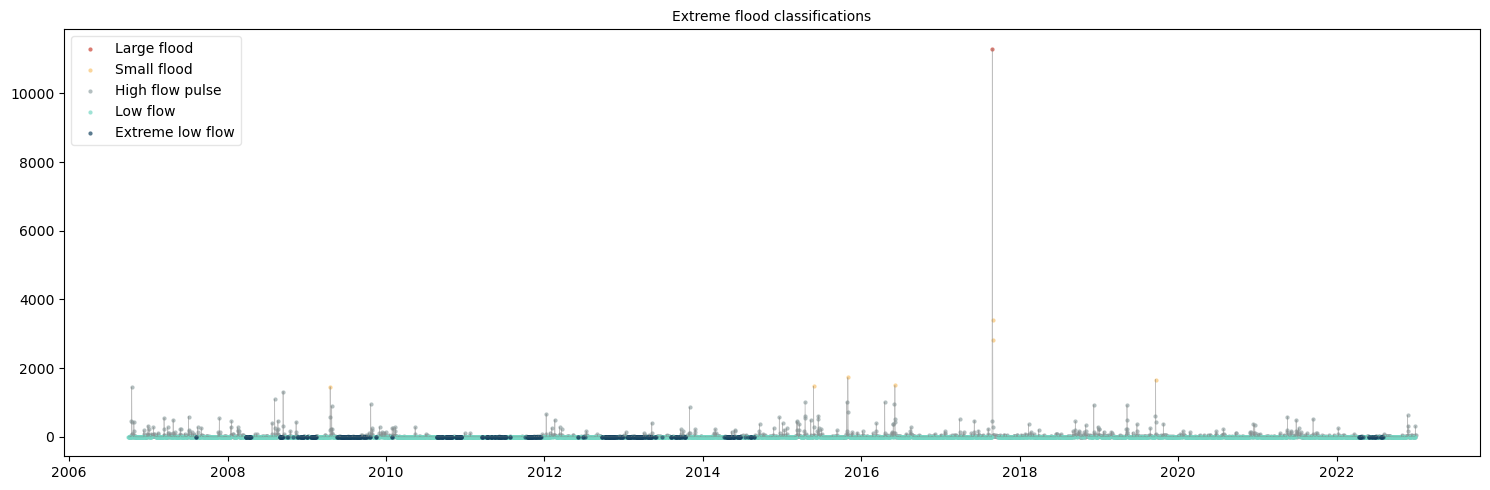

In [38]:
cpoi_id =  xr_streamflow.poi_id.values[12]

# Get subset of data to plot
#df_motion = df_motion.sort_index().loc['2020-07-10 13:55' : '2020-07-10 14:25.5', :] 

xr_streamflow = xr_streamflow.sortby('time', ascending=True)# bug fix for xarray
ds_sub = xr_streamflow.sel(poi_id=cpoi_id, time=slice('1980-10-01', '2022-12-31'))
ds_sub = ds_sub.to_dataframe()

# Or use entire dataset
#ds_sub = xr_merged.sel(poi_id=cpoi_id).to_dataframe()

# Plot EFC
plot_efc(ds_sub, flow_col)

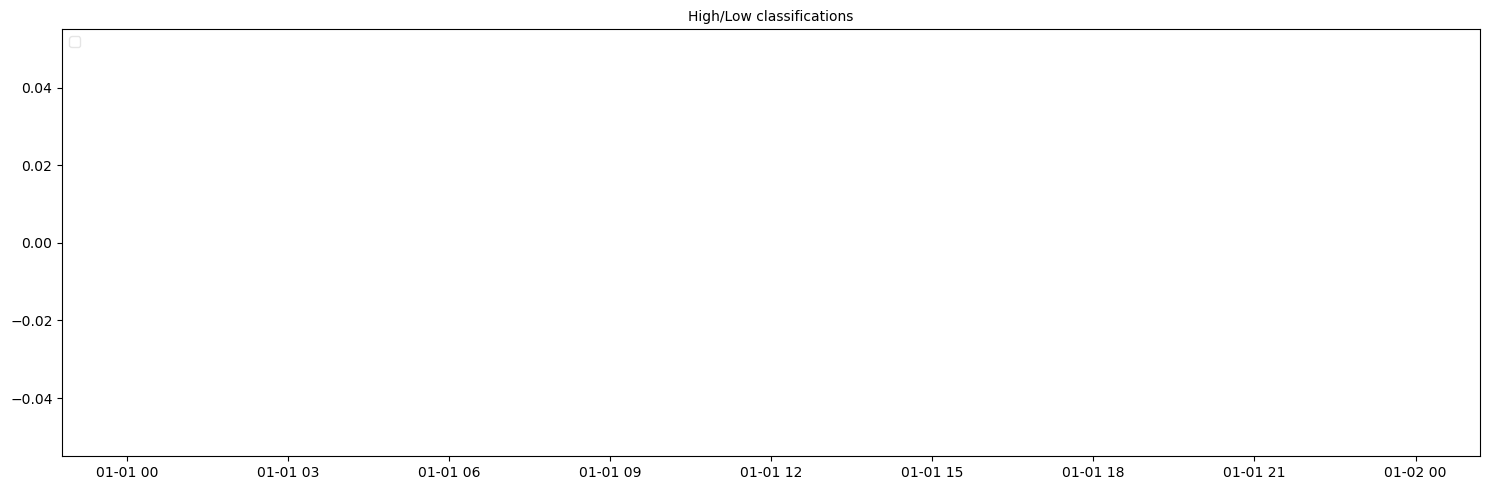

In [32]:
plot_high_low(ds_sub, flow_col)

## Write the Xarray data set to a netcdf file

In [33]:
if output_netcdf_filename.exists():
    con.print(f'The output file already exists. [bold]To re-write[/] the file, please [bold]remove[/] the existing file:')
    con.print(f'[bright_magenta]{output_netcdf_filename}[/]')
else:
    xr_streamflow.to_netcdf(output_netcdf_filename)

The output file already exists. To re-write the file, please remove the existing file:

C:\Projects\Repositories\OR_Recharge_Project\20240927_v1.1_gm_byHWons_san_jacinto_2\notebook_output_files\nc_files\
sf_efc.nc

In [34]:
#xr_streamflow